In [1]:
import os
NUM_THREADS = "12"
os.environ["OMP_NUM_THREADS"] = NUM_THREADS # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = NUM_THREADS # export OPENBLAS_NUM_THREADS=4
os.environ["MKL_NUM_THREADS"] = NUM_THREADS # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = NUM_THREADS # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = NUM_THREADS # export NUMEXPR_NUM_THREADS=6
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py as h5
import tqdm.notebook as tqdm

from lib import *

dx = 0.004149377593360996
dt_imp = 0.004149377593360996
dt = 0.004149377593360996
times.size : 387
times_imp.size : 387
saved_times.size : 387


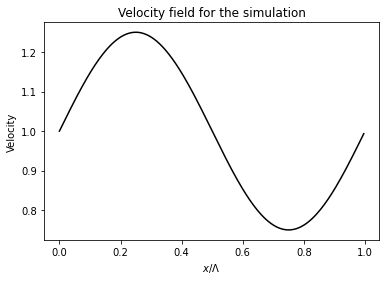

In [2]:
# Spatial discretisation
n=241
Lambda=1
x=Lambda*(np.arange(n)/n)
dx=x[1]-x[0]

# Velocity field
u = 1 + 0.25*np.sin(2*np.pi*x)
bux0 = lambda t : 1-0.5*np.pi*dx
buxL = lambda t : 1+0.5*np.pi*dx
T_adv = Lambda/u.max()

Lx = 0.15*Lambda
scale = Lx/dx
Lt = Lx/u[0]
dt_imp = Lt/scale
sub_sampling = 1
dt = dt_imp/sub_sampling

print("dx = {}".format(dx))
print("dt_imp = {}".format(dt_imp))
print("dt = {}".format(dt))
if dt>((0.5*dx)/u.max()):
    print("WARNING: CFL condition not satisfied")

# Time window
t_end = 2*T_adv + dt_imp
t_end = (t_end//dt_imp)*dt_imp
times = np.arange(0,t_end+dt,dt)
times_imp = times[::sub_sampling]
saved_times = times[::sub_sampling]
print("times.size : {}".format(times.size))
print("times_imp.size : {}".format(times_imp.size))
print("saved_times.size : {}".format(saved_times.size))

# Initial state
c0 = np.ones(n)

# Creates the boundary conditions for the forward and the TL models
bc = 'dirichlet'
bcx0 = lambda t : 1

bx0 = lambda t : (bcx0(t), bux0(t))
bxL = lambda t : (None, buxL(t))

model = Advection(x=x, u=u, bc=bc, bx0=bx0, bxL=bxL, time_scheme='rk4')

plot = True

if plot:
    plt.figure()
    plt.plot(model.x, model.u, c='k')
    plt.xlabel("$x/\Lambda$")
    plt.ylabel("Velocity")
    plt.title("Velocity field for the simulation");

In [3]:
V0 = 1

Lt0 = lambda t : Lt*(0.75 + 0.25*np.cos(2*np.pi*t/T_adv))

Vt0 = lambda t : V0*(1.25 - 0.25*np.cos(2*np.pi*t/T_adv))

temporal_variances = np.array([Vt0(t) for t in times_imp])
temporal_scales = np.array([Lt0(t) for t in times_imp])

spatial_variances = np.zeros(n) + V0
spatial_scales = np.zeros(n) + Lx

In [4]:

heterogeneous_boundary_time_serie = BoundaryTimeSerie(model, times_imp,
                                        spatial_variances=spatial_variances,
                                        spatial_scales=spatial_scales,
                                        temporal_variances=temporal_variances,
                                        temporal_scales = temporal_scales,
                                        transition_scale = u[0],
                                        offset = max(times_imp.size,n)
                                       )

  0%|          | 0/628 [00:00<?, ?it/s]

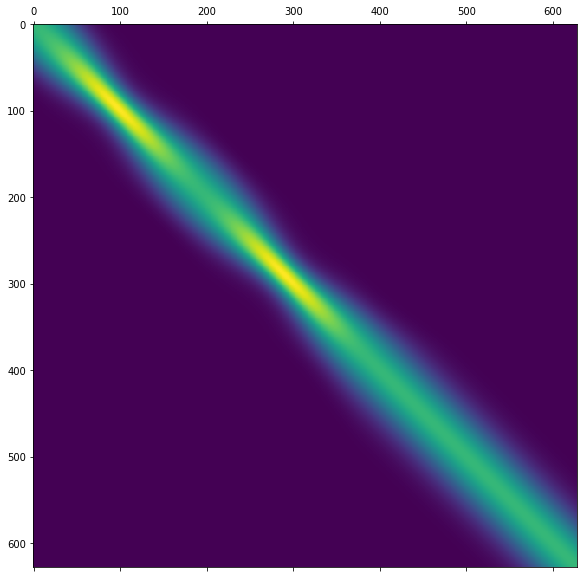

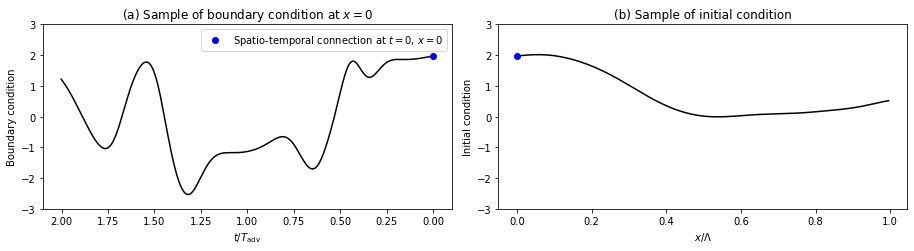

In [5]:
if plot:
    heterogeneous_boundary_time_serie.show_covariances()
    #plt.imshow(heterogeneous_boundary_time_serie._P[times_imp.size-30:times_imp.size+n+28,times_imp.size-30:times_imp.size+n+28])

    initial_condition, random_bc0, random_bcL = heterogeneous_boundary_time_serie.boundary_condition_factory()
    plt.figure(figsize=(12.8,3.6))
    plt.subplot(121)
    plt.plot(saved_times/T_adv, random_bc0(saved_times), c='k')
    plt.plot(0, random_bc0(0), 'bo', label='Spatio-temporal connection at $t=0$, $x=0$')
    plt.xlim(2.1,-0.1)
    plt.ylim(-3,3)
    plt.title("(a) Sample of boundary condition at $x=0$");
    plt.xlabel("$t/T_{\mathrm{adv}}$")
    plt.ylabel("$e$")
    plt.legend()
    plt.subplot(122)
    plt.plot(model.x, initial_condition, c='k')
    plt.plot(0, random_bc0(0), 'bo')
    plt.ylim(-3,3)
    plt.title("(b) Sample of initial condition");
    plt.xlabel("$x/\Lambda$")
    plt.tight_layout()
    plt.savefig("../figures/dirichlet-initial-error-samples.pdf")

In [6]:
heterogeneous_enkf_experiment = EnKFExperiment(model, heterogeneous_boundary_time_serie)
Ne = 6400
heterogeneous_enkf_experiment.run_ensemble(Ne=Ne, times=times, saved_times=saved_times, initial_condition=c0, bx0=bx0, bxL=bxL)

  0%|          | 0/6400 [00:00<?, ?it/s]

In [7]:
pkf_bx0 = lambda t : (bcx0(t), Vt0(t), Lt0(t)**2, bux0(t))
pkf_bxL = lambda t : (None, None, None, buxL(t))

pkf_model = AdvectionPKF(x=x, u=u, bc=bc, bx0=pkf_bx0, bxL=pkf_bxL, time_scheme='rk4')

pkf_state0 = np.zeros((3,n))
pkf_state0[0][:] = 1
pkf_state0[1][:] = spatial_variances
pkf_state0[2][:] = spatial_scales**2

pkf_traj = pkf_model.forecast(times, pkf_state0, saved_times=saved_times)

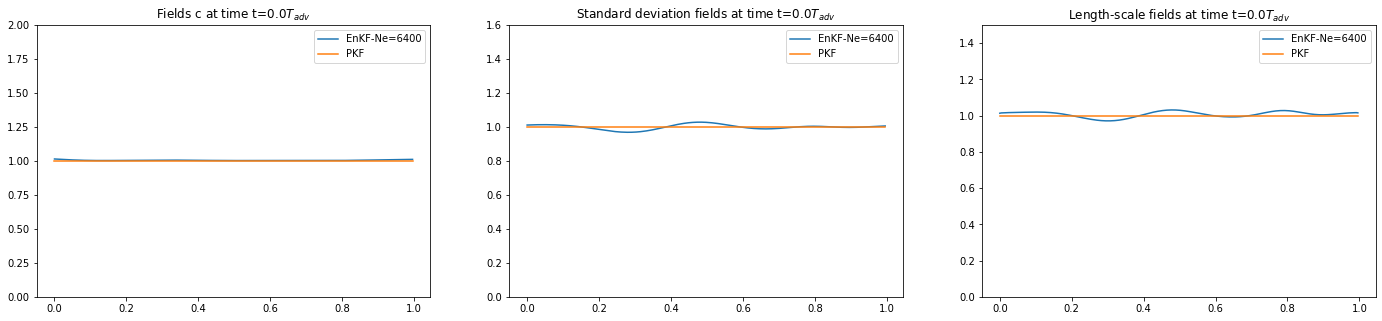

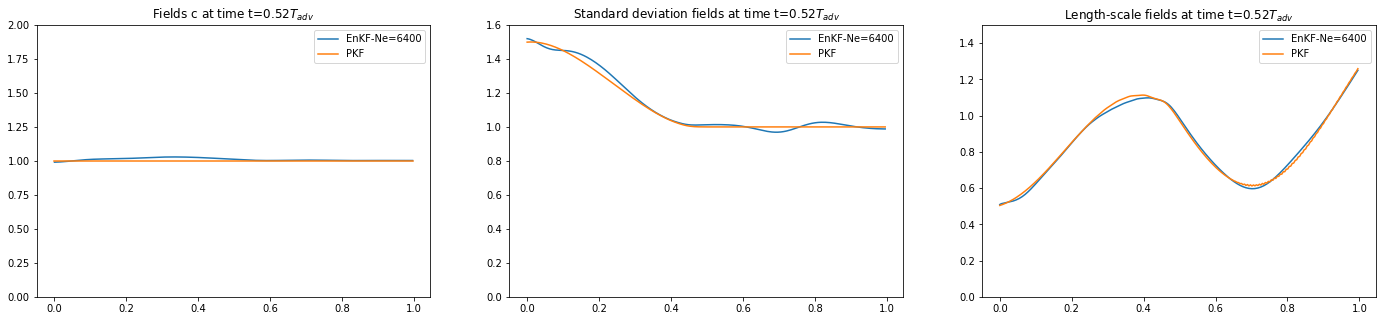

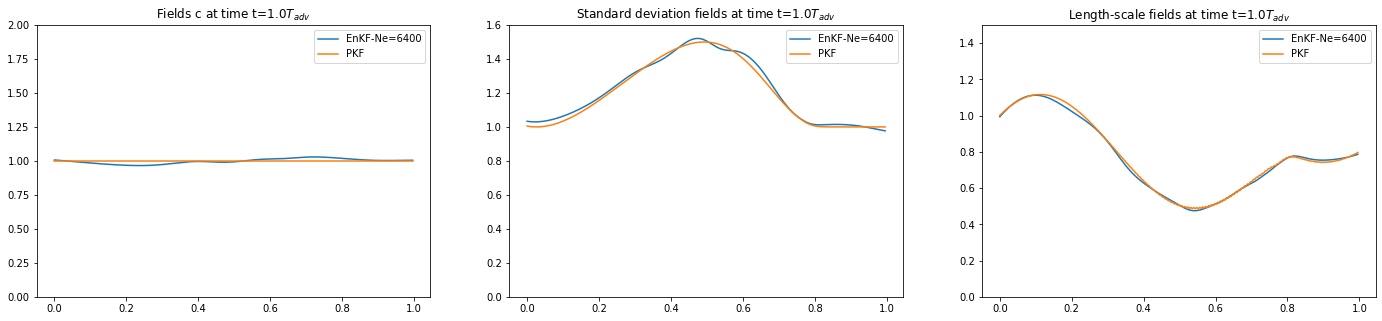

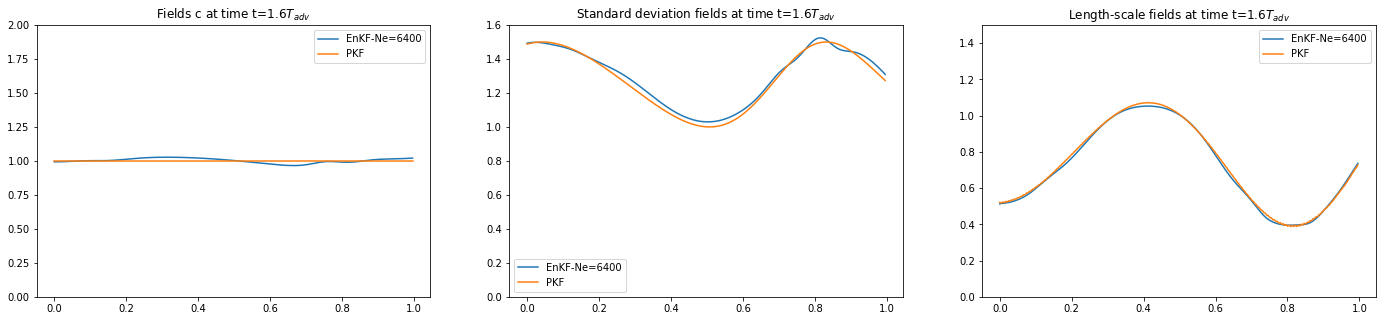

In [8]:
def plot_compare_at_t(t):
    plt.figure(figsize=(24,5))

    plt.subplot(131)
    plt.plot(model._x, heterogeneous_enkf_experiment.mean[t], label='EnKF-Ne={}'.format(heterogeneous_enkf_experiment.Ne))
    plt.plot(model._x, pkf_traj[t][0], label='PKF')
    plt.ylim(0,2)
    plt.title(f"Fields c at time t={t/T_adv:1.2}"+"$T_{adv}$")
    plt.legend()

    plt.subplot(132)
    plt.plot(model._x, heterogeneous_enkf_experiment.variances[t], label='EnKF-Ne={}'.format(heterogeneous_enkf_experiment.Ne))
    plt.plot(model._x, pkf_traj[t][1], label='PKF')
    plt.ylim(0,1.6)
    plt.title(f"Standard deviation fields at time t={t/T_adv:1.2}"+"$T_{adv}$")
    plt.legend()

    plt.subplot(133)
    plt.plot(model.x, heterogeneous_enkf_experiment.length_scales[t]/Lx,label=f'EnKF-Ne={heterogeneous_enkf_experiment.Ne}')
    plt.plot(model.x, np.sqrt(pkf_traj[t][2])/Lx,label='PKF')
    plt.ylim(0,1.5)
    plt.title(f"Length-scale fields at time t={t/T_adv:1.2}"+'$T_{adv}$')
    plt.legend()

if plot:
    for t in saved_times[::100]:
        plot_compare_at_t(t)
        plt.show()

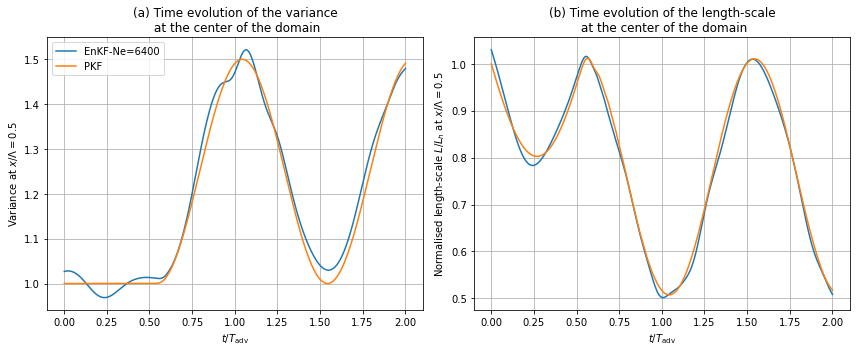

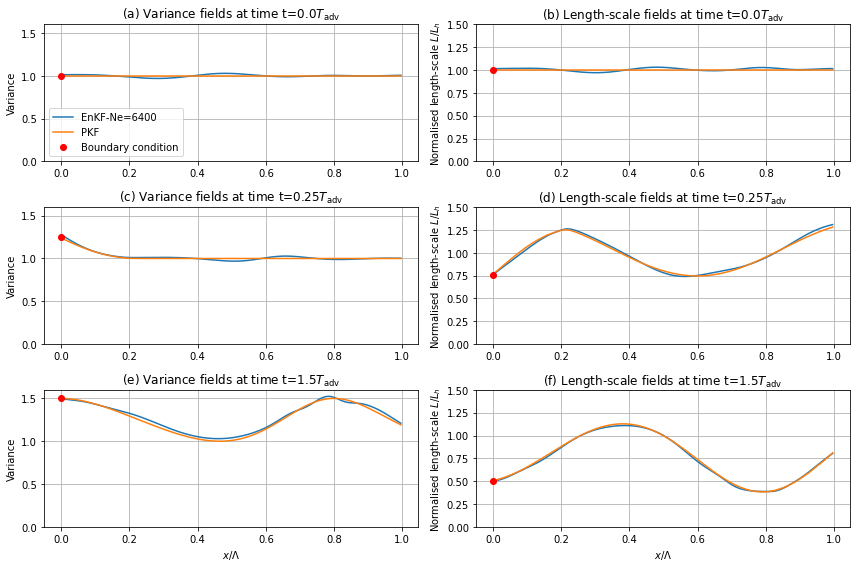

In [9]:
if plot:
    plt.figure(figsize=(12,5))

    plt.subplot(121)
    plt.plot(saved_times/T_adv, [heterogeneous_enkf_experiment.variances[t][120] for t in saved_times], label='EnKF-Ne={}'.format(heterogeneous_enkf_experiment.Ne))
    plt.plot(saved_times/T_adv, [pkf_traj[t][1][120] for t in saved_times], label='PKF')
    plt.title('(a) Time evolution of the variance\n at the center of the domain')
    plt.xlabel('$t/T_{\mathrm{adv}}$')
    plt.ylabel('Variance at $x/\Lambda=0.5 $')
    plt.legend()
    plt.grid()

    plt.subplot(122)
    plt.plot(saved_times/T_adv, [heterogeneous_enkf_experiment.length_scales[t][120]/Lx for t in saved_times], label='EnKF-Ne={}'.format(heterogeneous_enkf_experiment.Ne))
    plt.plot(saved_times/T_adv, [np.sqrt(pkf_traj[t][2][120])/Lx for t in saved_times], label='PKF')
    plt.title('(b) Time evolution of the length-scale\n at the center of the domain')
    plt.xlabel('$t/T_{\mathrm{adv}}$')
    plt.ylabel('Normalised length-scale $L/L_h$ at $x/\Lambda=0.5 $')
    plt.grid()

    plt.tight_layout()

    plt.savefig('../figures/PKF-heterogeneous-advection-dirichlet-timeseries.pdf')


plot_times = [0, 48, 290]
letters = 'abcdef'

if plot:
    plt.figure(figsize=(12,8))

    for i in range(3):
        index = plot_times[i]
        plt.subplot(321 + 2*i)
        plt.plot(model._x, heterogeneous_enkf_experiment.variances[saved_times[index]], label='EnKF-Ne={}'.format(heterogeneous_enkf_experiment.Ne))
        plt.plot(model._x, pkf_traj[saved_times[index]][1], label='PKF')
        plt.plot(0, pkf_bx0(saved_times[index])[1], 'ro', label='Boundary condition')
        plt.ylim(0,1.6)
        plt.title("("+letters[2*i]+")"+f" Variance fields at time t={saved_times[index]/T_adv:1.2}"+"$T_{\mathrm{adv}}$")
        plt.ylabel('Variance')
        if i==0:
            plt.legend()
        if i==2:
            plt.xlabel("$x/\Lambda$")
        plt.grid()

        plt.subplot(322 + 2*i)
        plt.plot(model.x, heterogeneous_enkf_experiment.length_scales[saved_times[index]]/Lx,label=f'EnKF-Ne={heterogeneous_enkf_experiment.Ne}')
        plt.plot(model.x, np.sqrt(pkf_traj[saved_times[index]][2])/Lx,label='PKF')
        plt.plot(0, np.sqrt(pkf_bx0(saved_times[index])[2])/Lx, 'ro')
        plt.ylim(0,1.5)
        plt.title("("+letters[2*i+1]+")"+f" Length-scale fields at time t={saved_times[index]/T_adv:1.2}"+'$T_{\mathrm{adv}}$')
        plt.ylabel('Normalised length-scale $L/L_h$')
        if i==2:
            plt.xlabel("$x/\Lambda$")
        plt.grid()

    plt.tight_layout()
    plt.savefig('../figures/PKF-heterogeneous-advection-dirichlet-time-comparison.pdf')